In [1]:
!pip install -Uqq fastai

In [5]:
#hide
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys')

In [6]:
# import mnist dataset from fastai
path = untar_data(URLs.MNIST_SAMPLE)

In [7]:
#hide
Path.BASE_PATH = path

View training data

In [8]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

There's a folder of 3s, and a folder of 7s. In machine learning parlance, we say that "3" and "7" are the labels (or targets) in this dataset. Let's take a look in one of these folders (using sorted to ensure we all get the same order of files):

In [9]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [10]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [11]:
#hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


Create tensors out of the images using list comprehension!

In [12]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

Create tensors of the validation data as well:

In [23]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Can use `show_image` function from Fast.ai to view a tensor of pixels as an image.

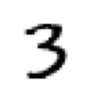

In [13]:
show_image(three_tensors[1]);

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. To do this we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a rank-3 tensor. We often need to stack up individual tensors in a collection into a single tensor. Unsurprisingly, PyTorch comes with a function called stack that we can use for this purpose.

Some operations in PyTorch, such as taking a mean, require us to cast our integer types to float types. Since we'll be needing this later, we'll also cast our stacked tensor to float now. Casting in PyTorch is as simple as typing the name of the type you wish to cast to, and treating it as a method.

Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:

In [15]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

Perhaps the most important attribute of a tensor is its shape. This tells you the length of each axis. In this case, we can see that we have 6,131 images, each of size 28×28 pixels. There is nothing specifically about this tensor that says that the first axis is the number of images, the second is the height, and the third is the width—the semantics of a tensor are entirely up to us, and how we construct it. As far as PyTorch is concerned, it is just a bunch of numbers in memory.

The length of a tensor's shape is its rank:

In [16]:
len(stacked_threes.shape)

3

We already have our independent variables x—these are the images themselves. We'll concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor). We can do this using view, which is a PyTorch method that changes the shape of a tensor without changing its contents. -1 is a special parameter to view that means "make this axis as big as necessary to fit all the data":

In [17]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

Label each image. 1 for 3's and 0 for 7's. Combine these labels into a tensor `train_y`.

In [19]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A Dataset in PyTorch is required to return a tuple of (x,y) when indexed. Python provides a zip function which, when combined with list, provides a simple way to get this functionality. This combines the input and expected output into a list of tuples.

In [21]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

Now do the same thing for the validation data. Need to concatenate the validation image tensors, then create a `valid_y` tensor that labels what each of the validation data points are. Then can combine these two into a Dataset just like the training data.

In [24]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))
x,y = valid_dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

Now we need an initially random weight for every pixel (this is the initialize step in our 7 step process):

In [25]:
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

In [26]:
weights = init_params((28*28,1))

Initialize `b` to a random number as well!

In [27]:
bias = init_params(1)

In neural networks, the `w` in the equation `y=w*x+b` is called the weights, and `b` is called the bias. Together, the weights and bias make up the parameters.

We can now calculate a prediction for one image.

In [28]:
(train_x[0]*weights.T).sum() + bias

tensor([1.4574], grad_fn=<AddBackward0>)

While we could use a Python for loop to calculate the prediction for each image, that would be very slow. Because Python loops don't run on the GPU, and because Python is a slow language for loops in general, we need to represent as much of the computation in a model as possible using higher-level functions.

In this case, there's an extremely convenient mathematical operation that calculates w*x for every row of a matrix—it's called matrix multiplication.

In Python, matrix multiplication is represented with the `@` operator. 

In [29]:
def linear1(xb):
    return xb@weights + bias

preds = linear1(train_x)
preds

tensor([[  1.4574],
        [ 15.8800],
        [  2.2931],
        ...,
        [-22.3284],
        [-12.8770],
        [-18.6255]], grad_fn=<AddBackward0>)

Here we make use of the `@` operator to execute matrix multiplication. This multiplies the tensor that is passed into the `linear` function by the `weights` tensor and adds the resulting tensor to the `bias` tensor. This should return a tensor with a single value for each image in the input parameter. This value represents a prediction for each image.

The first element is the same as what we calculated before manually. This should indicate to you they are doing the same math behind the scenes.

Let's check our accuracy. To decide if an output represents a 3 or a 7, we can just check whether its greater than 0.0, so our accuracy for each item can be calcuated (using broadcasting, so no loops!) with:

In [30]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[True],
        [True],
        [True],
        ...,
        [True],
        [True],
        [True]])

In [31]:
corrects.float().mean().item()

0.7455630898475647

Let's see what the change in accuracy is given a very small change to the weights.

In [32]:
with torch.no_grad(): weights[0] *= 1.0001

In [33]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.7455630898475647

As we've seen, we need gradients in order to improve our model using SGD, and in order to calculate gradients we need some loss function that represents how good our model is. That is because the gradients are a measure of how that loss function changes with small tweaks to the weights.

So, we need to choose a loss function. The obvious approach would be to use accuracy, which is our metric, as our loss function as well. In this case, we would calculate our prediction for each image, collect these values to calculate an overall accuracy, and then calculate the gradients of each weight with respect to that overall accuracy.

Unfortunately, we have a significant technical problem here. The gradient of a function is its slope, or its steepness, which can be defined as rise over run—that is, how much the value of the function goes up or down, divided by how much we changed the input. We can write this in mathematically as: (y_new - y_old) / (x_new - x_old). This gives us a good approximation of the gradient when x_new is very similar to x_old, meaning that their difference is very small. But accuracy only changes at all when a prediction changes from a 3 to a 7, or vice versa. The problem is that a small change in weights from x_old to x_new isn't likely to cause any prediction to change, so (y_new - y_old) will almost always be 0. In other words, the gradient is 0 almost everywhere.

A very small change in the value of a weight will often not actually change the accuracy at all. This means it is not useful to use accuracy as a loss function—if we do, most of the time our gradients will actually be 0, and the model will not be able to learn from that number.

Instead, we need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss. So what does a "slightly better prediction" look like, exactly? Well, in this case, it means that if the correct answer is a 3 the score is a little higher, or if the correct answer is a 7 the score is a little lower.

Let's write such a function now. What form does it take?

The loss function receives not the images themselves, but the predictions from the model. Let's make one argument, prds, of values between 0 and 1, where each value is the prediction that an image is a 3. It is a vector (i.e., a rank-1 tensor), indexed over the images.

The purpose of the loss function is to measure the difference between predicted values and the true values — that is, the targets (aka labels). Let's make another argument, trgts, with values of 0 or 1 which tells whether an image actually is a 3 or not. It is also a vector (i.e., another rank-1 tensor), indexed over the images.

So, for instance, suppose we had three images which we knew were a 3, a 7, and a 3. And suppose our model predicted with high confidence (0.9) that the first was a 3, with slight confidence (0.4) that the second was a 7, and with fair confidence (0.2), but incorrectly, that the last was a 7. This would mean our loss function would receive these values as its inputs:

In [34]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

Here's a first try at a loss function that measures the distance between predictions and targets:

In [35]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

We're using a new function, torch.where(a,b,c). This is the same as running the list comprehension [b[i] if a[i] else c[i] for i in range(len(a))], except it works on tensors, at C/CUDA speed. In plain English, this function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances.

note: Read the Docs: It's important to learn about PyTorch functions like this, because looping over tensors in Python performs at Python speed, not C/CUDA speed! Try running help(torch.where) now to read the docs for this function, or, better still, look it up on the PyTorch documentation site.

In [36]:
help(torch.where)

Help on built-in function where in module torch:

where(...)
    where(condition, input, other, *, out=None) -> Tensor
    
    Return a tensor of elements selected from either :attr:`input` or :attr:`other`, depending on :attr:`condition`.
    
    The operation is defined as:
    
    .. math::
        \text{out}_i = \begin{cases}
            \text{input}_i & \text{if } \text{condition}_i \\
            \text{other}_i & \text{otherwise} \\
        \end{cases}
    
    .. note::
        The tensors :attr:`condition`, :attr:`input`, :attr:`other` must be :ref:`broadcastable <broadcasting-semantics>`.
    
    Arguments:
        condition (BoolTensor): When True (nonzero), yield input, otherwise yield other
        input (Tensor or Scalar): value (if :attr:`input` is a scalar) or values selected at indices
                              where :attr:`condition` is ``True``
        other (Tensor or Scalar): value (if :attr:`other` is a scalar) or values selected at indices
                

From Chat GPT:

torch.where() is a PyTorch function that returns a tensor with elements selected from either the x tensor or the y tensor, depending on the condition specified. It has the following syntax:

`torch.where(condition, x, y)`

condition: This is a boolean tensor that specifies which elements to choose from x or y. Wherever the condition is True, the corresponding element from x is selected; otherwise, the corresponding element from y is selected.

x: This is the tensor containing elements to choose from where the condition is True.

y: This is the tensor containing elements to choose from where the condition is False.

In the mnist_loss function, predictions are the output probabilities from the model, and targets are the ground truth labels (binary in this case, usually 0 or 1 for binary classification tasks like MNIST digit classification).

So, the torch.where(targets==1, 1-predictions, predictions) call does the following:

Wherever targets is equal to 1 (indicating the positive class), it selects 1-predictions. This means if the target is 1 (positive class), it wants the loss to be high when the prediction is low (close to 0), hence 1-predictions.

Wherever targets is not equal to 1 (indicating the negative class), it selects predictions. This means if the target is not 1 (negative class), it wants the loss to be high when the prediction is high (close to 1), hence predictions.

Finally, .mean() computes the mean of all the selected elements, which represents the average loss across all samples in the batch.

In summary, the mnist_loss function computes a binary cross-entropy loss for binary classification tasks like MNIST digit classification, penalizing incorrect predictions differently based on whether they are for the positive or negative class.

Let's try it on our prds and trgts:

In [37]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [38]:
mnist_loss(prds,trgts)

tensor(0.4333)

One problem with mnist_loss as currently defined is that it assumes that predictions are always between 0 and 1. We need to ensure, then, that this is actually the case! As it happens, there is a function that does exactly that—let's take a look.

The sigmoid function always outputs a number between 0 and 1. It's defined as follows:

In [39]:
def sigmoid(x): return 1/(1+torch.exp(-x))

Let's update mnist_loss to first apply sigmoid to the inputs:

In [40]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

Having defined a loss function, now is a good moment to recapitulate why we did this. After all, we already had a metric, which was overall accuracy. So why did we define a loss?

The key difference is that the metric is to drive human understanding and the loss is to drive automated learning. To drive automated learning, the loss must be a function that has a meaningful derivative. It can't have big flat sections and large jumps, but instead must be reasonably smooth. This is why we designed a loss function that would respond to small changes in confidence level. This requirement means that sometimes it does not really reflect exactly what we are trying to achieve, but is rather a compromise between our real goal and a function that can be optimized using its gradient. The loss function is calculated for each item in our dataset, and then at the end of an epoch the loss values are all averaged and the overall mean is reported for the epoch.

Metrics, on the other hand, are the numbers that we really care about. These are the values that are printed at the end of each epoch that tell us how our model is really doing. It is important that we learn to focus on these metrics, rather than the loss, when judging the performance of a model.

Now that we have a loss function that is suitable for driving SGD, we can consider some of the details involved in the next phase of the learning process, which is to change or update the weights based on the gradients. This is called an optimization step.

we calculate the average loss for a few data items at a time. This is called a mini-batch. The number of data items in the mini-batch is called the batch size. A larger batch size means that you will get a more accurate and stable estimate of your dataset's gradients from the loss function, but it will take longer, and you will process fewer mini-batches per epoch. Choosing a good batch size is one of the decisions you need to make as a deep learning practitioner to train your model quickly and accurately. 

Instead of simply enumerating our dataset in order for every epoch, we randomly shuffle our dataset on every epoch, before we create mini-batchs. PyTorch and fastai provide a class that will do the shuffling and mini-batch collation for you called a `DataLoader`.

A `DataLoader` can take any Python collection and turn it into an iterator over mini-batchs, like so:

In [41]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 2,  9,  6,  8, 10]),
 tensor([ 7,  5, 11,  4, 14]),
 tensor([12, 13,  3,  1,  0])]

For training a model, we want a collection containing independent and dependent variables (inputs and targets of the model). A collection that contains tuples of independent and dependent variables is known in PyTorch as a Dataset. Here's an example of an extremely simple Dataset:

In [42]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

When we pass a Dataset to a DataLoader we will get back mini-batches which are themselves tuples of tensors representing batches of independent and dependent variables:

In [43]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([12, 24,  3, 14, 21,  8]), ('m', 'y', 'd', 'o', 'v', 'i')),
 (tensor([22,  0, 10,  2, 20,  6]), ('w', 'a', 'k', 'c', 'u', 'g')),
 (tensor([ 1, 15, 13, 16,  9,  5]), ('b', 'p', 'n', 'q', 'j', 'f')),
 (tensor([19, 17, 23, 18,  4, 25]), ('t', 'r', 'x', 's', 'e', 'z')),
 (tensor([ 7, 11]), ('h', 'l'))]

Now we can get started training our MNIST model using SGD!

First let's re-initialize our parameters:

In [44]:
weights = init_params((28*28,1))
bias = init_params(1)

A `DataLoader` can be created from a `Dataset`:

In [45]:
# dset is the tensor of tuples we created earlier with the
# input and correct answers for the training data

dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

We'll do the same for the validation set:

In [46]:
# valid_dset is the tensor of tuples we created earlier with the
# input and correct answers for the validation data

valid_dl = DataLoader(valid_dset, batch_size=256)

Let's create a mini-batch of size 4 for testing:

In [47]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

Then feed that mini-batch into our model

In [48]:
preds = linear1(batch)
preds

tensor([[ -6.4616],
        [ -5.7044],
        [-12.4600],
        [ -2.5384]], grad_fn=<AddBackward0>)

Calculate the loss:

In [50]:
# use train_y[:4] b/c the mini-batch was made from the first 4
# training data in train_x

loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.9805, grad_fn=<MeanBackward0>)

Now we can calculate the graidents. Once we have the gradients, we can use that to step our parameters and improve the model!

In [52]:
# calc gradients on the loss (step need to min(loss))

loss.backward()

# gradients are calc'd and stored on each param as a tensor

weights.grad.shape,weights.grad.mean(),bias.grad

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

That is the bulk of the training steps. After that we'd just need to actually update the parameters.

Before we do that, let's put those steps we just covered in a function. It should:
1. generate a prediction based on a batch of input data
2. calculate the loss on the predictions (how accurate it was)
3. calculate the gradients

In [54]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

Now test it using our test mini-batch:

In [55]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0063), tensor([-0.0364]))

But look what happens if we call it twice:

In [56]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0095), tensor([-0.0545]))

The gradients have changed! The reason for this is that loss.backward actually adds the gradients of loss to any gradients that are currently stored. So, we have to set the current gradients to 0 first:

In [57]:
weights.grad.zero_()
bias.grad.zero_();

note: Inplace Operations: Methods in PyTorch whose names end in an underscore modify their objects in place. For instance, bias.zero_() sets all elements of the tensor bias to 0.

Our only remaining step is to update the weights and biases based on the gradient and learning rate. When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise things will get very confusing when we try to compute the derivative at the next batch! If we assign to the data attribute of a tensor then PyTorch will not take the gradient of that step. Here's our basic training loop for an epoch:

In [58]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

We also want to check how we're doing, by looking at the accuracy of the validation set. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0. So our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [59]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [False],
        [False]])

That gives us this function to calculate our validation accuracy:

In [60]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [61]:
# test out batch_accuracy with test mini-batch

batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

Put the batches together

In [62]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [64]:
validate_epoch(linear1)

0.4958

That's our starting point. Let's train for one epoch, and see if the accuracy improves:

In [66]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6414

Then do a few more:

In [67]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8353 0.9037 0.9276 0.9369 0.9437 0.9481 0.9496 0.951 0.952 0.9545 0.9574 0.9584 0.9593 0.9598 0.9628 0.9632 0.9637 0.9632 0.9637 0.9637 

Our next step will be to create an object that will handle the SGD step for us. In PyTorch, it's called an optimizer.

PyTorch has some built in helper functions in its API we can use to accomplish this. The first thing we can do is replace our `linear1` function with PyTorch's `nn.Linear` module. A module is an objet of a class that inherits from the PyTorch `nn.Module` class. Objects of this class behave identically to standard Python functions, in that you can call them using parentheses and they will return the activations of a model.

`nn.Linear` does the same thing as our `init_params` and `linear` together. It contains both the weights and biases in a single class. Here's how we replicate our model from the previous section:

In [68]:
linear_model = nn.Linear(28*28,1)

Every PyTorch module knows what parameters it has that can be trained; they are available through the parameters method:

In [69]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

For more information on the PyTorch `nn.Linear` module, see the PyTorch docs:
https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

```python
CLASStorch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
```

Parameters
in_features (int) – size of each input sample

out_features (int) – size of each output sample

bias (bool) – If set to False, the layer will not learn an additive bias. Default: True

We can now create the optimizer:

In [70]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [72]:
# init optimizer using PyTorch model params

opt = BasicOptim(linear_model.parameters(), lr)

Our training loop can now be simplified to:

In [73]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [74]:
validate_epoch(linear_model)

0.4087

Create a function for the training process to make things simpler.

In [77]:
def train_model(model, epoch):
    for i in range(epoch):
        train_epoch(model)
        print(validate_epoch(linear_model))

In [78]:
train_model(linear_model, 20)

0.4932
0.9042
0.8086
0.9067
0.9311
0.9453
0.9555
0.9609
0.9653
0.9672
0.9687
0.9706
0.9736
0.975
0.976
0.976
0.9775
0.978
0.978
0.9789


fastai provides the SGD class which, by default, does the same thing as our BasicOptim:

In [80]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932
0.8579
0.8335
0.9111
0.9326
0.9467
0.9555
0.9628
0.9653
0.9667
0.9692
0.9716
0.9741
0.9745
0.976
0.976
0.9775
0.9775
0.978
0.978


fastai also provides Learner.fit, which we can use instead of train_model. To create a Learner we first need to create a DataLoaders, by passing in our training and validation DataLoaders:

In [81]:
dls = DataLoaders(dl, valid_dl)

To create a Learner without using an application (such as vision_learner) we need to pass in all the elements that we've created in this chapter: the DataLoaders, the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:

In [82]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

Now we can call `learn.fit()`

In [83]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636949,0.503485,0.495584,00:00
1,0.525086,0.196720,0.831698,00:00
2,0.192815,0.177026,0.843474,00:00
3,0.084355,0.104670,0.913150,00:00
4,0.044425,0.076647,0.933759,00:00
5,0.028853,0.061567,0.948970,00:00
6,0.022471,0.052192,0.956330,00:00
7,0.019645,0.045948,0.962218,00:00
8,0.018222,0.041548,0.965653,00:00
9,0.017374,0.038294,0.967125,00:00


As you can see, there's nothing magic about the PyTorch and fastai classes. They are just convenient pre-packaged pieces that make your life a bit easier! (They also provide a lot of extra functionality we'll be using in future chapters.)

With these classes, we can now replace our linear model with a neural network.

So far we have a general procedure for optimizing the parameters of a function, and we have tried it out on a very boring function: a simple linear classifier. A linear classifier is very constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.

We can implement a Neural Network using the PyTorch API

In [84]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

nn.Sequential creates a module that will call each of the listed layers or functions in turn.

nn.ReLU is a PyTorch module that does exactly the same thing as the F.relu function. Most functions that can appear in a model also have identical forms that are modules. Generally, it's just a case of replacing F with nn and changing the capitalization. When using nn.Sequential, PyTorch requires us to use the module version. Since modules are classes, we have to instantiate them, which is why you see nn.ReLU() in this example.

Because nn.Sequential is a module, we can get its parameters, which will return a list of all the parameters of all the modules it contains. Let's try it out! As this is a deeper model, we'll use a lower learning rate and a few more epochs.

In [85]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [86]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.359349,0.369360,0.588322,00:00
1,0.162169,0.240583,0.793425,00:00
2,0.087394,0.118116,0.913150,00:00
3,0.055755,0.078874,0.940137,00:00
4,0.041351,0.061403,0.954367,00:00
5,0.034169,0.051662,0.963690,00:00
6,0.030155,0.045523,0.966634,00:00
7,0.027612,0.041328,0.968597,00:00
8,0.025815,0.038281,0.969578,00:00
9,0.024438,0.035965,0.970069,00:00


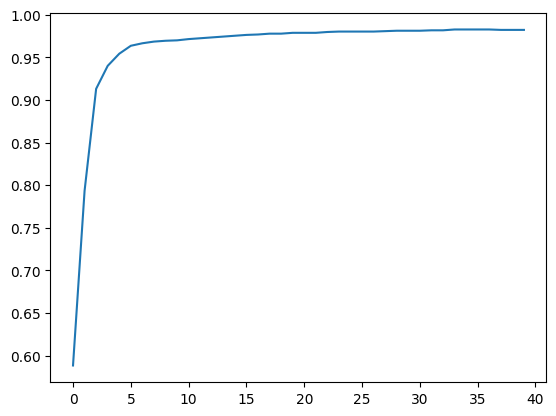

In [87]:
plt.plot(L(learn.recorder.values).itemgot(2));

We can view the final accuracy of the model that was just trained.

In [88]:
learn.recorder.values[-1][2]

0.98233562707901